# Notebook to illustrate the use of the perturbed loss

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_spd_matrix
import torch
import numpy as np

common_seed = 42

def draw_samples(n, d):
    cov_x = make_sparse_spd_matrix(dim=d, random_state=42,alpha=0.99, smallest_coef=0, largest_coef=0.22)
    diag_x = np.eye(d)
    for i in range(d//2):
        diag_x[i,i] = 20
    cov_x = cov_x + diag_x
    #cov_x[1,1] = 20
    mu_x = np.random.randn(d)
    x = np.random.multivariate_normal(mu_x, cov_x, size=n)
    cov_y = np.eye(d)
    cov_y = make_sparse_spd_matrix(dim=d, random_state=43)
    mu_y =  np.random.randn(d) 
    mu_y[0:d//2] =  mu_y[0:d//2] + 20
    #mu_y[0] =  mu_y[0] + 10 #1dim is the most important
    y = np.random.multivariate_normal(mu_y, cov_y, size=n)  
    return torch.tensor(x).float(), torch.tensor(y).float()


## Illustration of the impact of the optimizer

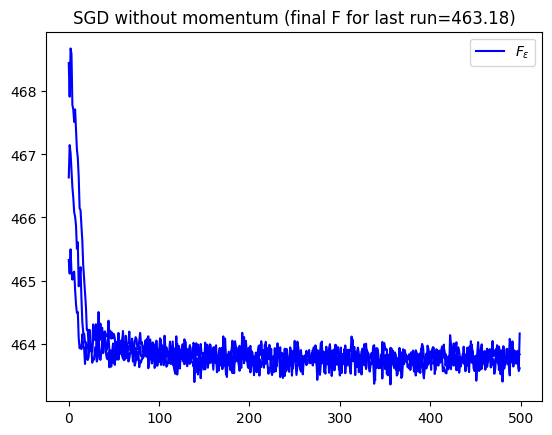

In [2]:
from losses import F_eps, F
from torch.optim import SGD, Adam

n = 100
epsilon = .1
n_samples = 10
d = 3
x, y = draw_samples(n, d)
learning_rate = 0.005
n_iter = 500
n_reps = 3

torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"SGD without momentum (final F for last run={float(F(x, y, theta)):.2f})");
print()

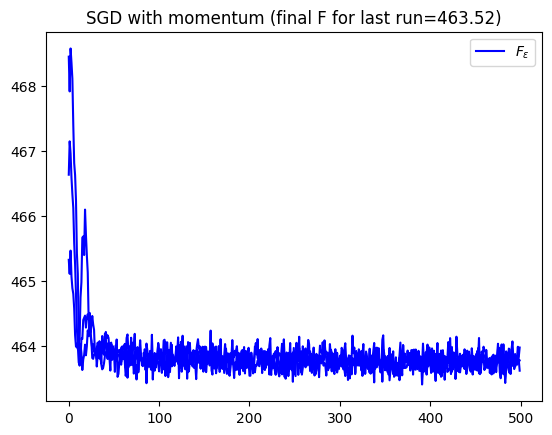

In [3]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=.9)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"SGD with momentum (final F for last run={float(F(x, y, theta)):.2f})");

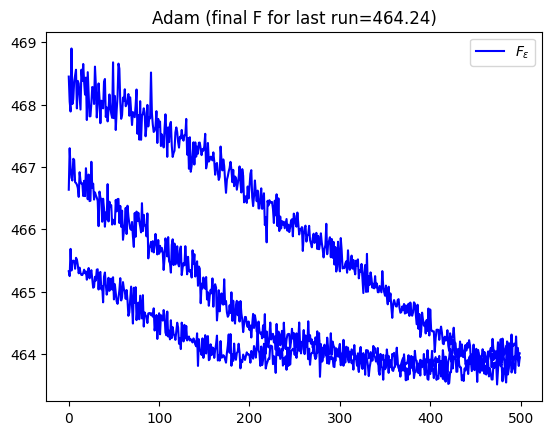

In [4]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = Adam([theta], lr=0.001)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Adam (final F for last run={float(F(x, y, theta)):.2f})");

## Example of using a different $F$ function (here $W_1$ in place of $W_2^2$)

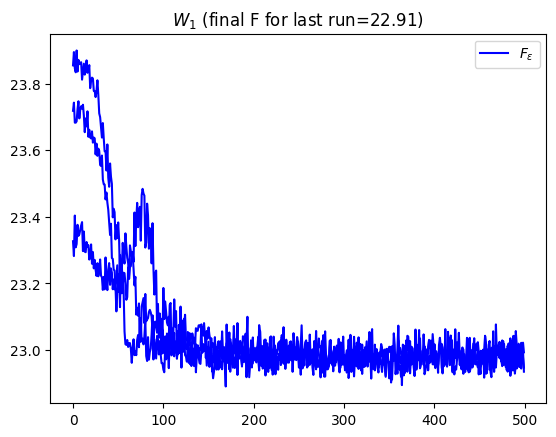

In [5]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, theta: F(x, y, theta, p=1)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"$W_1$ (final F for last run={float(custom_F(x, y, theta)):.2f})");